In [ ]:
import pandas as pd
import os
import numpy as np
from scipy import signal
from emprime_convert import _text_to_df

def filter_signal(dat:np.ndarray, 
                  band=[1,40], 
                  sampling_rate:int=500):
    # data: 1D array
    [b, a] = signal.iirnotch(60, 30, sampling_rate) # power noise
    dat = signal.filtfilt(b, a, dat)
    [b, a] = signal.butter(3, band, 'bandpass', fs=sampling_rate)
    dat = signal.filtfilt(b, a, dat)
    # dat =  np.convolve(dat, np.ones(sampling_rate//20) / (sampling_rate//20), mode='same')
    return dat

def preprocess_d2_data(fs = 125, num_trials = 96):
    ROOT_PATH = r'D:/One_한양대학교/private object minsu/coding/data/samsung_2024/Day 2/'
    fs_origin = 500
    num_total_trials = 1320

    subj_list = os.listdir(ROOT_PATH)
    for idx, subj in enumerate(subj_list):
        dat_list = os.listdir(ROOT_PATH+subj+'/d2/')
        save_path = f'./d2_data/S{idx}/'
        os.makedirs(save_path, exist_ok=True)
        num1, num2 = (2, 5) if len(dat_list) < 7 else (3, 7)

        easy_ = np.asarray(pd.read_csv(ROOT_PATH + subj + '/d2/' + dat_list[num1], delimiter='\t')).T
        easy = easy_[:,0::2]
        event = np.append(np.where(easy[8]==4)[0], np.where(easy_[8,1::2]==4)[0])
        event.sort()
        event = np.append(event, np.where(easy_[8]==5)[0][-1]//2)//4
        end = easy.shape[1]//fs_origin
        easy = easy[:8,:end*fs_origin]
        easy = filter_signal(easy)
        easy = signal.resample(easy, fs*end, axis=1)

        # compute CONC
        txt = _text_to_df(ROOT_PATH + subj + '/d2/' + dat_list[num2])
        txt = np.asarray(txt.loc[:,['CorrectKey', 'd2test.RESP']])[:-1]
        conc = []
        for seg, i in enumerate(range(0, num_total_trials-num_trials, num_trials//2)):
            tmp = txt[i:i+96]
            conc.append((tmp[(tmp[:,0]==tmp[:,1]) & (tmp[:,0] == '1')].shape[0] - np.sum(tmp[:,0]!=tmp[:,1])) / num_trials)
            ttt = easy[:,event[i]:event[i+num_trials]]
            np.save(save_path + f'segment{seg}.npy', easy[:,event[i]:event[i+num_trials]])
        np.save(save_path + 'conc.npy',np.array(conc,float))

preprocess_d2_data()

In [5]:
conc = np.load('./d2_data/S0/conc.npy')
segment0 = np.load('./d2_data/S0/segment1.npy')

In [ ]:
"""
PATH: d2_data/S{subject_num}/
    - conc.npy: size = (26,), CONC values of 96 trials with 50 % overlap
    - segment{num}.npy: size = (8,x) where x = length of 96 trials
        - 8 electrode channels: Fp(AF7, FPZ, AF8), Central (C3, CZ, C4), Ear (Left, Right) 
        - 125 Hz downsampled, 1-40 Hz bandpass filtered, 60 Hz notch filtered
    - There are a total of 26 segments corresponding to each of the 26 CONC values.
TODO
    - Divide each segments by an epoch (you can choose your own epoch size). 
    - Labels for those epochs are corresponding CONC value.
    - You can determine threshold values for CONC values to make it binaray classification task.
""" 

'\nemotion_data: shape (33, 9, 8, 15000) = (num_subject, trials, electrode channels, time samples)\n    trials (9 trials): resting, happy/peaceful, sad/angry \n    electrode channels (8 channels): Fp(AF7, FPZ, AF8), Central (C3, CZ, C4), Ear (Left, Right) \n    time samples: 125 Hz downsampled, 1-40 Hz bandpass filtered, 60 Hz notch filtered\n\nNOTE: signal for resting state is concatenated signal (60 sec eyes open + 60 sec eyes closed)\n\nemotion_label: shape (33, 9, 2) = (num_subject, trials, emotional state)\n    emotional state: idx 0 is for arousal, and idx 1 is for valence. scored 1 to 5.\n\nNOTE: you can transform score label into binary label (pos/neg valence and high/low arousal), as follows:\n        new_emotion_label = np.array(emotion_label>2,int)\n'

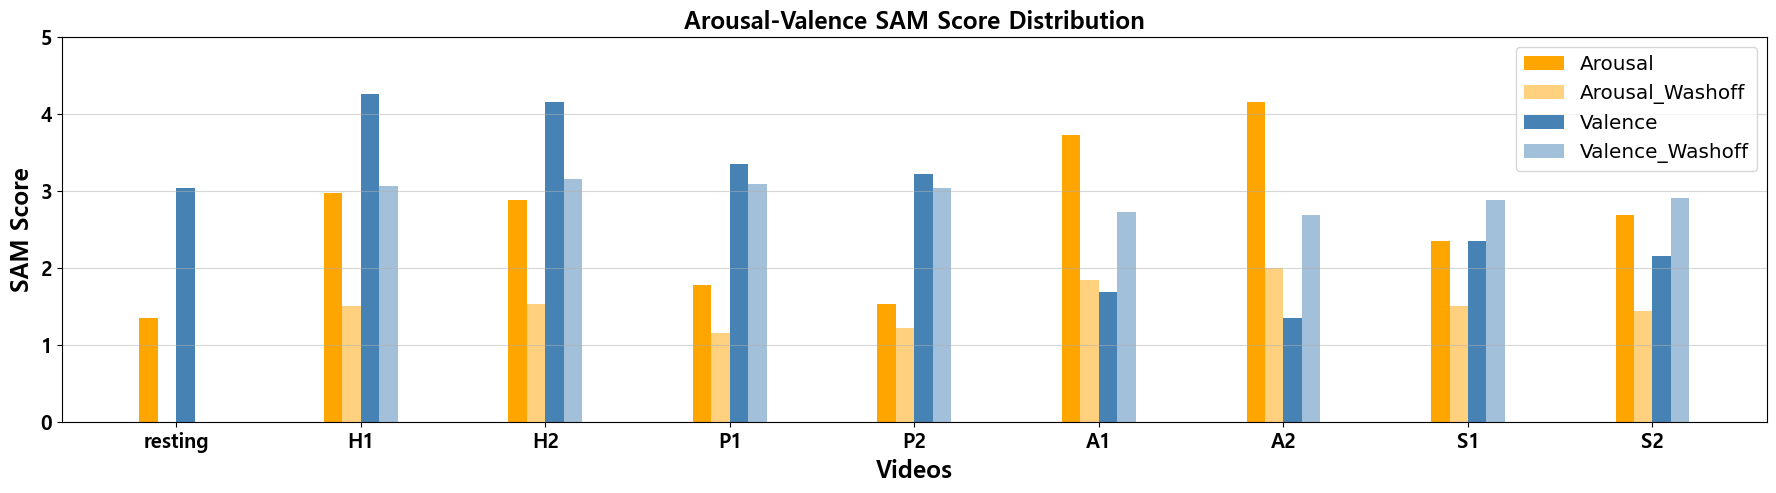

In [101]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

def Plot_Emotion_Label_Distribution():
    ROOT_PATH = r'D:/One_한양대학교/private object minsu/coding/data/samsung_2024/Day 1/'
    subj_list = os.listdir(ROOT_PATH)
    videos = ['resting','H1','H2','P1','P2','A1','A2','S1','S2']
    num_videos = len(videos)

    emotion_label_ = np.zeros((len(subj_list), num_videos, 4), int)
    for idx, subj in enumerate(subj_list):
        dat_list = os.listdir(ROOT_PATH + subj)

        label_raw = pd.read_csv(ROOT_PATH + subj + '/' + [s for s in dat_list if 'Emotion' in s][0])
        emotion_label_[idx,:,:2] = np.array(label_raw[videos][:2]).T
        emotion_label_[idx,1:,2:] = np.array(label_raw[['H1w','H2w','P1w','P2w','A1w','A2w','S1w','S2w']][:2]).T

    plt.figure(figsize=(22,5))
    bar_width = 0.1
    index = np.arange(0,num_videos,1)

    mean_emotion_label = np.mean(emotion_label_,0)
    std_emotion_label = np.std(emotion_label_,0)

    plt.grid(axis='y',alpha=.5)
    bar1 = plt.bar(index - bar_width, mean_emotion_label[:,0], bar_width, alpha=1, color = 'orange', label = 'Arousal')# , yerr=std_emotion_label[:,0])
    bar3 = plt.bar(index, mean_emotion_label[:,2], bar_width, alpha=.5, color = 'orange', label = 'Arousal_Washoff')# , yerr=std_emotion_label[:,2])
    bar2 = plt.bar(index + bar_width, mean_emotion_label[:,1], bar_width, alpha=1, color = 'steelblue', label = 'Valence')# , yerr=std_emotion_label[:,1])
    bar4 = plt.bar(index + bar_width*2, mean_emotion_label[:,3], bar_width, alpha=.5, color = 'steelblue', label = 'Valence_Washoff')# , yerr=std_emotion_label[:,3])
    plt.xticks(np.arange(bar_width/2, num_videos+bar_width/2, 1), videos, fontweight='bold', fontsize='x-large', fontfamily='Malgun Gothic')
    plt.yticks(np.arange(0,6,1), fontweight='semibold',fontsize='x-large', fontfamily='Malgun Gothic')
    plt.title('Arousal-Valence SAM Score Distribution', fontsize='xx-large', fontweight='bold', fontfamily='Malgun Gothic')
    plt.ylabel("SAM Score", fontsize='xx-large', fontweight='bold', fontfamily='Malgun Gothic')
    plt.xlabel("Videos", fontsize='xx-large', fontweight='bold', fontfamily='Malgun Gothic')
    plt.legend(['Arousal','Arousal_Washoff','Valence','Valence_Washoff'], fontsize='x-large')

Plot_Emotion_Label_Distribution()